In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

/usr/local/lib/python3.10/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.10/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} = 
f(\mathbf{x}) = \begin{bmatrix} 
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} = 
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [2]:
# an example of how actions are resolved
# # head_direction_t0 = head_direction[0] # norm'd by pi
# head_direction_t1 = head_direction[1] # norm'd by pi
# agent_angle_complex_vec_t0 = episode_log['infos'][0][0]['angle']
# agent_angle_complex_vec_t1 = episode_log['infos'][1][0]['angle']
# print(f"agent_angle_t0: {agent_angle_complex_vec_t0}")
# print(f"agent_angle_t1: {agent_angle_complex_vec_t1}")

# agent_angle_rad_t0 = np.angle(agent_angle_complex_vec_t0[0] + 1j*agent_angle_complex_vec_t0[1], deg=False) # not norm'd by pi 0.30103736300307615
# agent_angle_rad_t1 = np.angle(agent_angle_complex_vec_t1[0] + 1j*agent_angle_complex_vec_t1[1], deg=False) # not norm'd by pi 0.6844864019832495
# print(f"t0 angle rad = {agent_angle_rad_t0}")
# print(f"t1 angle rad = {agent_angle_rad_t1}")


# action_t0 = episode_log['actions'][0]
# action_t1 = episode_log['actions'][1]
# action_t0_sq = np.clip((np.tanh(action_t0) + 1)/2, 0.0, 1.0) # squash action
# action_t1_sq = np.clip((np.tanh(action_t1) + 1)/2, 0.0, 1.0) # squash action
# turn_action_t0 = action_t0_sq[1]
# turn_action_t1 = action_t1_sq[1]
# # turn_action = 1 - turn_action # invert turn action
# # print(f"turn_action: {turn_action}")
# # # print(f"action_t0_sq: {action_t0_sq}")
# turn_capacity = 6.25*np.pi
# turnx = 1
# dt = env_dt = 0.04
# # print(f"turn by {turn_capacity*turnx*(turn_action_t1 - 0.5)*dt} rad")
# my_agent_angle_rad_t1 = agent_angle_rad_t0 + turn_capacity*turnx*(turn_action_t1 - 0.5)*dt # in radians; (Turn~[0, 1], with 0.5 = no turn, <0.5 turn cw, >0.5 turn ccw)
# print(f"sim new angle rad = {my_agent_angle_rad_t1}")




In [3]:
state_names = [
                'x',  # x position [m]
                'y',  # y position [m]
                'v_para',  # parallel ground velocity [m/s]
                'v_perp',  # perpendicular ground velocity [m/s]
                'phi', # heading [rad]
                'w',  # ambient wind speed [m/s]
                'zeta',  # ambient wind angle [rad]
                ]

input_names = [
                'u_para',  # translational speed [m/s]
                'u_phi',  # angular velocity [rad/s]
                'u_para_dot'  # translational acceleration [m/s^2] 
                ]

def f(X, U):
    '''
    Return Xdot given X and U
    
    X: state vector
        v_para: ground velocity in the direction parallel to head direction (egocentric frame) [m/s]
        v_perp: ground velocity perpendicular to head direction (egocentric frame) [m/s]
        phi: heading [rad]
        w: wind speed [m/s]
        zeta: wind angle [rad]
    U: input vector assuming actions have been squashed and scaled
        u_para: translational speed [m/s]
        u_phi: angular velocity [rad/s]
        u_para_dot: translational acceleration [m/s^2]
    '''
    # States
    # v_para, v_perp, phi, w, zeta = X
    x, y, v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot = U # keep u_para because it is in the observation matrix

    # Dynamics
    w_dot = 0*w # wind speed is constant
    zeta_dot = 0*zeta # wind angle is constant NOTE: may be time varying
    phi_dot = u_phi # angular velocity is controlled by agent
    v_perp_dot = - w * np.cos(phi - zeta) * u_phi # omit terms that would be zero
    # v_perp_dot = -w * np.cos(phi - zeta) * u_phi # omit terms that would be zero
    # v_perp_dot = -w * np.cos(phi - zeta) * u_phi + w * np.cos(phi - zeta) * zeta_dot - w_dot * np.sin(phi - zeta) 
    v_para_dot = - w * np.sin(phi - zeta) * u_phi + u_para_dot # omit terms that would be zero
    # v_para_dot = -w * np.sin(phi - zeta) * u_phi + w * np.sin(phi - zeta) * zeta_dot + w_dot * np.cos(phi - zeta) + u_para_dot
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)

    # Package and return xdot
    X_dot = [x_dot, y_dot, v_para_dot, v_perp_dot, phi_dot, w_dot, zeta_dot]
    # X_dot = [v_para_dot, v_perp_dot, phi_dot, w_dot, zeta_dot]

    return X_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [4]:
measurement_names = ['phi', 'appWind', 'psi'] # heading, apparent wind parallel component, drift angle/egocentric course angle
def h(X, U):
    '''
    Measurement functions - input is the state and control input; output is the measurement
    Assuming control signals are squashed and scaled
    '''
    # States
    x, y, v_para, v_perp, phi, w, zeta = X
    # v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot = U
    
    # Measurements
    # Heading
    phi = phi # heading is directly observable 
    # Apparent wind
    appWind = - u_para # equal and opposite to translational speed which is in line with head direction and thus have only a parallel component
    # Course direction in fly reference frame
    psi = np.arctan2(v_perp, v_para) # drift angle / egocentric course angle  # TODO numerically check if this is actually the drift angle - yes according to Ben
    
    # # Unwrap angles - Elliot unwrap the angles s.t. they are continuous - no more snapping back to 0
    # if np.array(phi).ndim > 0:
    #     if np.array(phi).shape[0] > 1:
    #         phi = np.unwrap(phi)
    #         psi = np.unwrap(psi)
    #         # gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, appWind, psi]

    # Return measurement
    return Y


## Set time-step

In [5]:
dt = 0.04  # [s]

# Create simulator object

In [6]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

# Can also set the number of state (n) & inputs (m0 instead of state & input names)
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Load inference-time trajectories to pull out control signals

In [7]:
log_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/constantx5b5.pkl'
# load pkl file
import pickle
import numpy as np
with open(log_fname, 'rb') as f_handle:
    episode_logs = pickle.load(f_handle)
print('Loaded episode logs from', log_fname)
print('Number of episodes:', len(episode_logs))
print('Episodes contain:', episode_logs[0].keys())
print('For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb')

Loaded episode logs from /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/constantx5b5.pkl
Number of episodes: 240
Episodes contain: dict_keys(['trajectory', 'observations', 'actions', 'rewards', 'infos', 'activity'])
For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb


In [8]:
raw_actions = episode_logs[0]['actions']
# TODO: function that squashes and scales actions. output is u_sim a dict with keys 'u_para', 'u_phi', 'u_para_dot', and values are np arrays
# stack a list of actions into a 2D array
raw_actions = np.stack(raw_actions)

def squash_and_scale_actions(raw_actions, dt):
    '''
    See /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb
    
    Logged actions are the raw outputs of the agent. They need to be translated into the control inputs for the simulator.
    1. Squash the actions to [0, 1]
    2. Scale the actions to the fly's capabilities
    3. Calculate the translational acceleration - new need to be checked
    4. Return a dictionary of control inputs for the simulator
    
    Note at agent_angle_rad_t0, this is obtained by the following steps:
      - t = -1: env generates an obs by env.reset()
      - t = 0: policy creates an action based on the obs
      - t = 0: env.step(action)
          - t = 0: obs_t0 = obs_t(-1) + action_t0  (obs_t-1 based on how the angle was initialized which is NOT documented in the eps logs)
      - t = 1: env generates an obs
    '''
    
    def squash_action(x):
      return np.clip((np.tanh(x) + 1)/2, 0.0, 1.0) # squash action, center and scale to [0, 1], per action treatment 

    if type(raw_actions) is list:
      raw_actions = np.stack(raw_actions)
      
    # Vectorize the function # TODO sanity check
    vsquash_action = np.vectorize(squash_action)

    # Apply the vectorized function to the array
    actions = vsquash_action(raw_actions)

    # Scale actions by fly capabilities 
    actions[:, 0] = actions[:, 0] * 2.0 # Max agent speed in m/s
    actions[:, 1] = (actions[:, 1] - 0.5) * 6.25*np.pi # Max agent CW/CCW turn per second

    # Calculate translational acceleration
    acc = np.diff(actions[:, 0]) / dt # checked - this is correct
    # acc = np.insert(acc, 0, 0) # first acceleration is 0
    
    # Omit the first action. See function description.
    u_sim = {'u_para': actions[1:, 0], 'u_phi': actions[1:, 1], 'u_para_dot': acc} 
    print('u_sim shapes', u_sim['u_para'].shape, u_sim['u_phi'].shape, u_sim['u_para_dot'].shape)
    
    return u_sim

u_sim = squash_and_scale_actions(raw_actions, dt) # can be pulled from traj_df_stacked['step'] and 'turn'; just need to scale but already squashed

u_sim shapes (117,) (117,) (117,)


# Pull out ground truth states and measurements to be simulated 

In [9]:
import tamagotchi.eval.log_analysis as log_analysis
number_of_eps = 240 # pull all episodes
dataset = 'constantx5b5'
eval_folder = 'eval'
model_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/weights/plume_14421_37e2cd4be4c96943d0341849b40f81eb.pt'
traj_df_stacked = log_analysis.get_eval_dfs_and_stack_them(model_fname, dataset, number_of_eps, exp_dir=eval_folder, # full_model_dir = args.model_dir, 
                                                           oob_only=False,
                                                           balanced=False,
                                                           verbose=True) 

epoch_traj_df = traj_df_stacked[traj_df_stacked['ep_idx'] == 0]

Found                       idx  ep_length  log
dataset      outcome                     
constantx5b5 HOME     209        209  209
             OOB       31         31   31 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//constantx5b5.pkl, after filter by min 0 steps
Found                       idx  ep_length  log
dataset      outcome                     
constantx5b5 HOME     209        209  209
             OOB       31         31   31 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//constantx5b5.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/
model_seed ----> 14421
Found 3

240it [00:06, 38.17it/s]


Stacked traj dfs shape: (35148, 92)


In [10]:
gt_dict = {'x':[], 'y':[], 'v_para': [], 'v_perp': [], 'phi': [], 'w': [], 'zeta': [], 'psi_ego_course_dir': [], 'v_allo': []}
# gt_dict = {'v_para': [], 'v_perp': [], 'phi': [], 'w': [], 'zeta': [], 'psi_ego_course_dir': [], 'v_allo': []}

gt_dict['x'] = epoch_traj_df['loc_x'].values
gt_dict['y'] = epoch_traj_df['loc_y'].values
gt_dict['phi'] = np.angle(epoch_traj_df['agent_angle_x'] + 1j*epoch_traj_df['agent_angle_y'], deg=False)
gt_dict['w'] = epoch_traj_df['wind_speed_ground'].values
gt_dict['zeta'] = epoch_traj_df['wind_angle_ground_theta'].values # normalized by pi and then shifted to 0-1
gt_dict['psi_ego_course_dir'] = epoch_traj_df['ego_course_direction_theta'].values # normalized by pi and then shifted to 0-1
gt_dict['v_allo'] = np.stack(epoch_traj_df['allo_ground_velocity'].values) # PEv3: (np.array(self.agent_location) - self.agent_location_last)/self.dt; calc'd in get_eval_dfs_and_stack_them
gt_dict['v_allo_dt'] = np.diff(gt_dict['v_allo']) / dt # acceleration
# scale angles from 0-1 to -pi to pi
gt_dict['zeta'] = np.pi * (2*gt_dict['zeta'] - 1)
gt_dict['psi_ego_course_dir'] = np.pi * (2*gt_dict['psi_ego_course_dir'] - 1)

gt_dict['v_para'] = np.cos(gt_dict['psi_ego_course_dir']) * np.linalg.norm(np.stack(gt_dict['v_allo']), axis=1) # cos(psi) * g = v_para
gt_dict['v_perp'] = np.sin(gt_dict['psi_ego_course_dir']) * np.linalg.norm(np.stack(gt_dict['v_allo']), axis=1) # sin(psi) * g = v_perp

# log_shapes(gt_dict)

# Compare control signals with ground truth - acc and step check out

In [11]:
# u_para_dot is calculated correctly in that it matches the airspeed acceleration of the agent
    # the airspeed acceleration of the agent checked out in that it pointed in the head direction
air_velocity = np.stack(epoch_traj_df['air_velocity'].values)
air_velocity_angle = np.angle(air_velocity[:, 0] + 1j*air_velocity[:, 1], deg=False)
air_velocity_mag = np.linalg.norm(air_velocity, axis=1)
air_velocity_acc = np.diff(air_velocity_mag) / dt
print(np.allclose(air_velocity_acc, u_sim['u_para_dot'], atol=1e-4))

agent_angle = np.angle(epoch_traj_df['agent_angle_x'].values + 1j*epoch_traj_df['agent_angle_y'].values, deg=False)
print(np.allclose(air_velocity_angle, agent_angle, atol=1e-4))

True
True


In [12]:
# get acceleration in airspeed from ground truth
epoch_traj_df['step_scaled'] = epoch_traj_df['step'] * 2
epoch_traj_df['u_para_dot'] = epoch_traj_df['step_scaled'].diff() / dt

# are epoch_traj_df['u_para_dot'] and u_sim['u_para_dot'] the same, allow for a small tolerance? YES
print(np.allclose(epoch_traj_df['u_para_dot'].values[1:], u_sim['u_para_dot'], atol=1e-4)) 

True


# Simulate with control inputs to see if it matches ground truth

In [13]:
# x0 = np.array([gt_dict['x'][0], gt_dict['y'][0], gt_dict['v_para'][0], gt_dict['v_perp'][0], gt_dict['phi'][0], gt_dict['w'][0], gt_dict['zeta'][0]])
x0 = {'x': gt_dict['x'][0], 'y': gt_dict['y'][0], 'v_para': gt_dict['v_para'][0], 'v_perp': gt_dict['v_perp'][0], 'phi': gt_dict['phi'][0], 'w': gt_dict['w'][0], 'zeta': gt_dict['zeta'][0]}
# x0 = np.array([gt_dict['v_para'][0], gt_dict['v_perp'][0], gt_dict['phi'][0], gt_dict['w'][0], gt_dict['zeta'][0]])

In [14]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, mpc=False, u=u_sim, return_full_output=True)

In [15]:
import jax
import jax.numpy as jnp
def log_shapes(pytree):
    def log_leaf(path, leaf=()):
        if isinstance(leaf, jnp.ndarray) or isinstance(leaf, np.ndarray):
            print(f"Path: {path}, Shape: {leaf.shape}")
    jax.tree_util.tree_map_with_path(log_leaf, pytree)
log_shapes(x_sim)
log_shapes(u_sim)

Path: (DictKey(key='phi'),), Shape: (117,)
Path: (DictKey(key='v_para'),), Shape: (117,)
Path: (DictKey(key='v_perp'),), Shape: (117,)
Path: (DictKey(key='w'),), Shape: (117,)
Path: (DictKey(key='x'),), Shape: (117,)
Path: (DictKey(key='y'),), Shape: (117,)
Path: (DictKey(key='zeta'),), Shape: (117,)
Path: (DictKey(key='u_para'),), Shape: (117,)
Path: (DictKey(key='u_para_dot'),), Shape: (117,)
Path: (DictKey(key='u_phi'),), Shape: (117,)


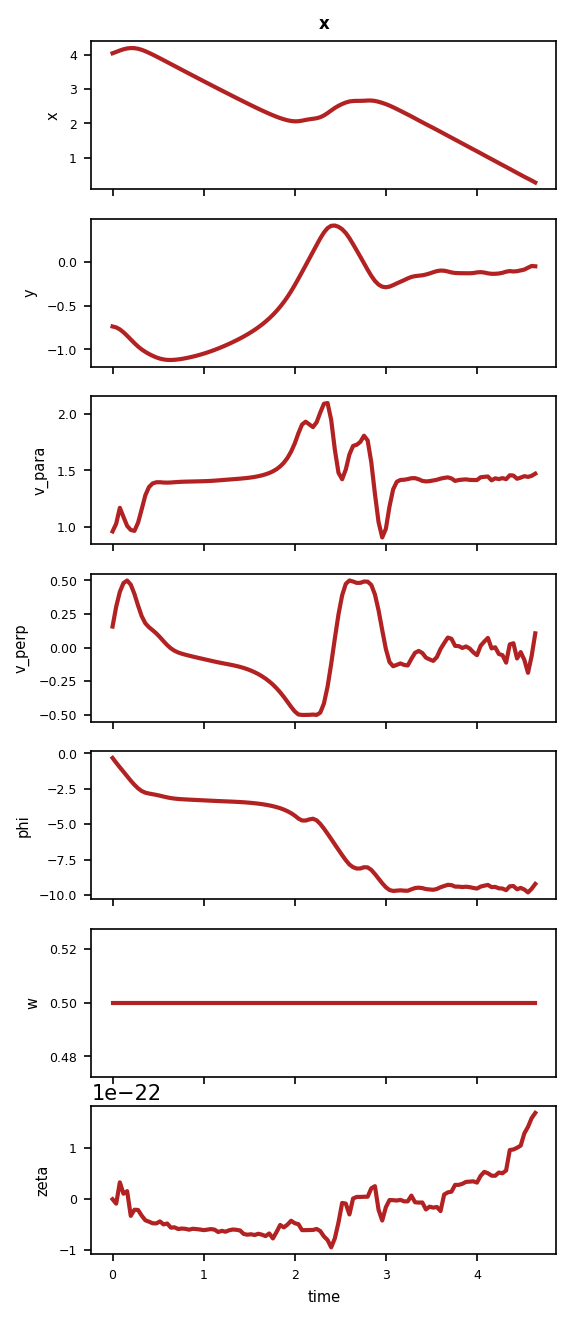

In [16]:
# Plot state
simulator.plot('x')

# Plot the ground truth and the simulated trajectories

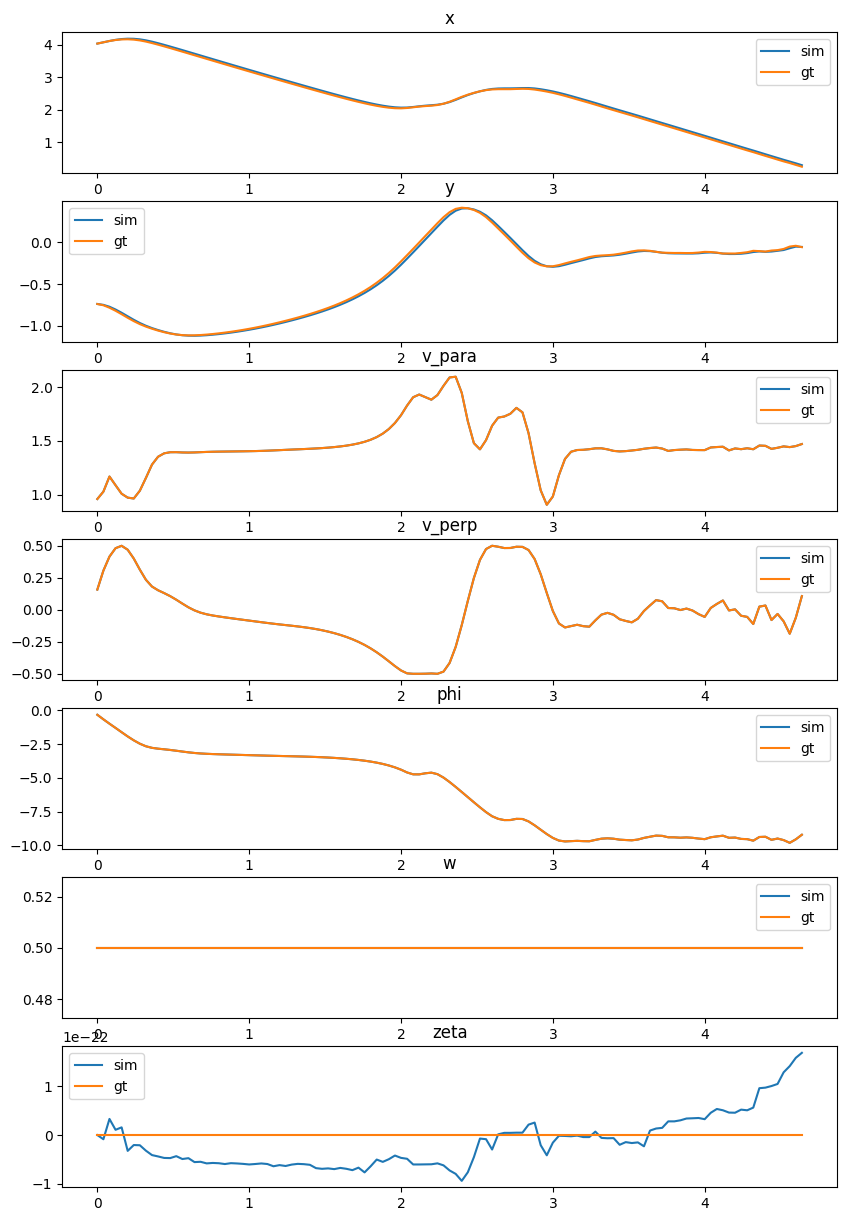

In [17]:
# plot ground truth
# plot each state in a separate plot, where x_sim is a dict 
gt_dict['phi'] = np.unwrap(gt_dict['phi'])
fig, axs = plt.subplots(7, 1, figsize=(10, 15)) # x y loc
# fig, axs = plt.subplots(5, 1, figsize=(10, 15))
for i, state_name in enumerate(state_names):
    axs[i].plot(t_sim, x_sim[state_name], label='sim')
    axs[i].plot(t_sim, gt_dict[state_name][:-1], label='gt')
    axs[i].set_title(state_name)
    axs[i].legend()
plt.show()

In [38]:
x_sim['zeta'] == gt_dict['zeta'][1:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [57]:
x_sim['phi']

array([-0.32033047, -0.65788683, -0.98048502, -1.29346002, -1.61152301,
       -1.92526769, -2.21389553, -2.46415111, -2.65397291, -2.77036782,
       -2.83198972, -2.87807651, -2.92720606, -2.98393417, -3.04491287,
       -3.10317873, -3.15111988, -3.18699885, -3.21239797, -3.2310275 ,
       -3.24621194, -3.26017504, -3.27351355, -3.28645342, -3.29906041,
       -3.3115871 , -3.32417443, -3.33682835, -3.3492411 , -3.3611043 ,
       -3.37227556, -3.3829492 , -3.39357774, -3.40478806, -3.41720915,
       -3.43141405, -3.44788199, -3.4670396 , -3.48929367, -3.51509361,
       -3.54497752, -3.57963679, -3.61997454, -3.66717605, -3.72277787,
       -3.78875304, -3.86760931, -3.9625103 , -4.0774055 , -4.21714501,
       -4.38751689, -4.5950229 , -4.73283635, -4.73507016, -4.65624441,
       -4.60859001, -4.7204971 , -4.97500419, -5.30308419, -5.66481831,
       -6.04114901, -6.4221703 , -6.80251767, -7.17687468, -7.53290329,
       -7.83990507, -8.02970176, -8.12297517, -8.119369  , -8.03

In [58]:
gt_dict['phi']

array([-0.32033047, -0.65788683, -0.98048503, -1.29346004, -1.61152303,
       -1.92526772, -2.21389556, -2.46415115, -2.65397296, -2.77036788,
       -2.83198978, -2.87807656, -2.92720613, -2.98393423, -3.04491292,
       -3.10317877,  3.13206541,  3.09618644,  3.07078732,  3.05215778,
        3.03697334,  3.02301025,  3.00967173,  2.99673186,  2.98412488,
        2.97159818,  2.95901086,  2.94635694,  2.93394419,  2.92208098,
        2.91090971,  2.90023608,  2.88960752,  2.87839719,  2.8659761 ,
        2.85177119,  2.83530325,  2.81614565,  2.79389157,  2.76809164,
        2.73820774,  2.70354847,  2.66321072,  2.61600921,  2.56040739,
        2.49443222,  2.41557595,  2.32067496,  2.20577976,  2.06604023,
        1.89566837,  1.68816236,  1.5503489 ,  1.54811508,  1.62694085,
        1.67459528,  1.56268818,  1.30818107,  0.98010107,  0.61836695,
        0.24203626, -0.13898501, -0.51933236, -0.89368935, -1.24971795,
       -1.55671973, -1.74651643, -1.83978984, -1.83618366, -1.74

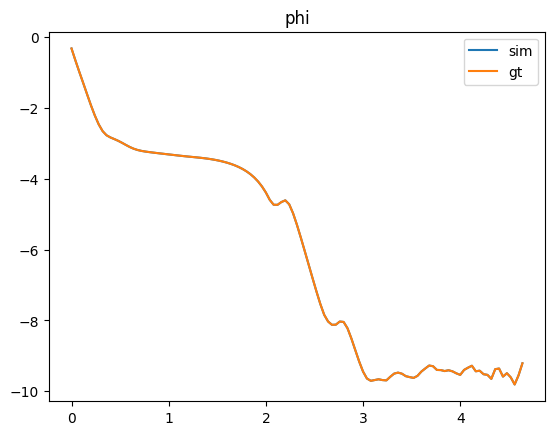

In [54]:
gt_phi_unwrapped = np.unwrap(gt_dict['phi'])
# plot gt phi and sim phi on the same plot
plt.plot(t_sim, x_sim['phi'], label='sim')
plt.plot(t_sim, gt_phi_unwrapped[:-1], label='gt')
plt.title('phi')
plt.legend()

In [69]:
gt_dict['phi']

array([-0.32033047, -0.65788683, -0.98048503, -1.29346004, -1.61152303,
       -1.92526772, -2.21389556, -2.46415115, -2.65397296, -2.77036788,
       -2.83198978, -2.87807656, -2.92720613, -2.98393423, -3.04491292,
       -3.10317877,  3.13206541,  3.09618644,  3.07078732,  3.05215778,
        3.03697334,  3.02301025,  3.00967173,  2.99673186,  2.98412488,
        2.97159818,  2.95901086,  2.94635694,  2.93394419,  2.92208098,
        2.91090971,  2.90023608,  2.88960752,  2.87839719,  2.8659761 ,
        2.85177119,  2.83530325,  2.81614565,  2.79389157,  2.76809164,
        2.73820774,  2.70354847,  2.66321072,  2.61600921,  2.56040739,
        2.49443222,  2.41557595,  2.32067496,  2.20577976,  2.06604023,
        1.89566837,  1.68816236,  1.5503489 ,  1.54811508,  1.62694085,
        1.67459528,  1.56268818,  1.30818107,  0.98010107,  0.61836695,
        0.24203626, -0.13898501, -0.51933236, -0.89368935, -1.24971795,
       -1.55671973, -1.74651643, -1.83978984, -1.83618366, -1.74

In [18]:
# v_perp_dot = -w * np.cos(phi - zeta) * u_phi # omit terms that would be zero

# a = np.cos(gt_dict['phi'] - gt_dict['zeta'])[:-1]
# b = np.cos(x_sim['phi'] - x_sim['zeta'])

a = np.sin(gt_dict['phi'] - gt_dict['zeta'])[:-1]
b = np.sin(x_sim['phi'] - x_sim['zeta'])

# a = np.cos(gt_dict['phi'] - gt_dict['zeta'])
# b = np.cos(x_sim['phi'] - x_sim['zeta'])
# pad the first element of b with 0
# b = np.insert(b, 0, 0)

if not np.allclose(a, b, atol=1e-1):
    # plot a and b on the same plot
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(a, label='gt')
    axs.plot(b, label='sim')
    axs.legend()
    plt.show()

# Observability

## Construct observability matrix in sliding windows

In [30]:
w = 10  # window size, set to None to use entire time-series as one window

In [31]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 12.12142276763916


In [32]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [33]:
n_window = len(O_sliding)
print(n_window, 'windows')

108 windows


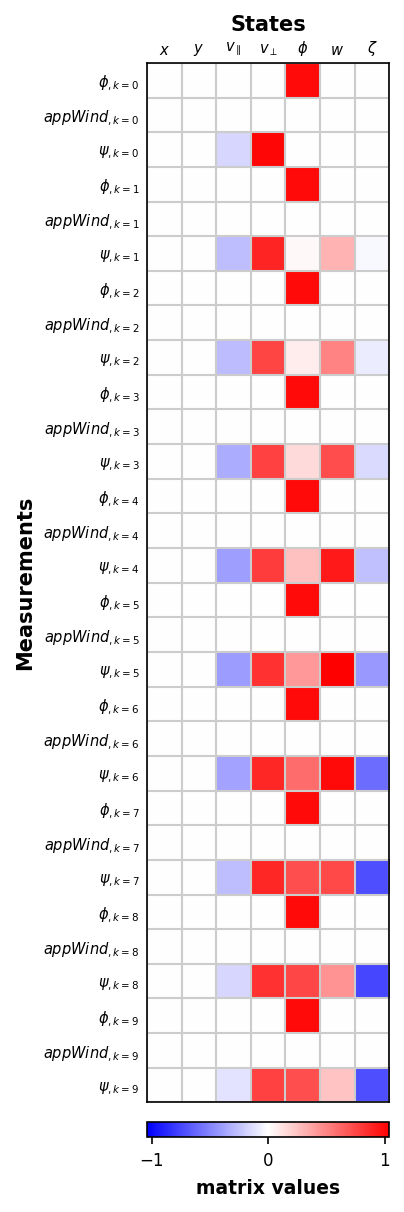

In [34]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [35]:
# Set each sensor noise level
sensor_noise = {'phi': 0, 'appWind': 0, 'psi': 0}
# sensor_noise = {'phi': 0.1, 'appWind': 0.1, 'psi': 0.1}

In [36]:
SEOM.O_df_sliding[0]

,,x,y,v_para,v_perp,phi,w,zeta
sensor,time_step,,,,,,,
phi,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00
appWind,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,0,0.000000e+00,0.000000e+00,-1.665380e-01,1.014914e+00,0.000000,0.000000e+00,0.000000e+00
phi,1,3.330669e-12,-1.665335e-12,-1.110223e-12,1.665335e-12,1.000000,-1.665335e-12,-5.551115e-13
appWind,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,1,-3.885781e-12,-3.325118e-10,-2.656388e-01,8.934892e-01,0.031127,3.069082e-01,-3.112681e-02
phi,2,6.106227e-12,-1.665335e-12,0.000000e+00,1.110223e-12,1.000000,-2.220446e-12,2.775558e-12
appWind,2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,2,-3.774758e-11,-1.493250e-10,-2.699902e-01,7.596598e-01,0.079446,4.978730e-01,-7.944545e-02


In [43]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=None, sensor_noise_dict=sensor_noise, lam=1e-12)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [45]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,y,v_para,v_perp,phi,w,zeta
x,1.000000e+06,4.403272e-07,1.224643e-03,2.087460e-04,-2.498006e-06,4.675539e-04,0.000391
y,4.403272e-07,1.000000e+06,-4.743575e-02,-7.587894e-03,2.331656e-06,-1.807174e-02,-0.018660
v_para,1.224643e-03,-4.743575e-02,1.428217e+02,2.528728e+01,-2.182571e-07,4.390586e+01,21.744281
v_perp,2.087460e-04,-7.587894e-03,2.528728e+01,4.536008e+00,-3.913096e-08,7.727781e+00,3.880879
phi,-2.498006e-06,2.331656e-06,-2.182571e-07,-3.913096e-08,1.000000e-02,-6.864173e-08,0.010000
w,4.675539e-04,-1.807174e-02,4.390586e+01,7.727781e+00,-6.864173e-08,1.358617e+01,6.718817
zeta,3.913207e-04,-1.866043e-02,2.174428e+01,3.880879e+00,9.999964e-03,6.718817e+00,3.446545


## Compute Fisher information matrix & inverse for each sliding window

In [57]:
# Choose sensors to use from O
o_sensors = ['phi', 'appWind', 'psi']

# Chose states to use from O
o_states = [
                # 'x',  # x position [m]
                # 'y',  # y position [m]
                'v_para',  # parallel ground velocity [m/s]
                'v_perp',  # perpendicular ground velocity [m/s]
                'phi', # heading [rad]
                'w',  # ambient wind speed [m/s]
                'zeta',  # ambient wind angle [rad]
                ]

# Choose time-steps to use from O
window_size = 10
o_time_steps = np.arange(0, window_size, step=1)

In [59]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
# SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=None, sensor_noise_dict=sensor_noise,
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=0.1, #sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [60]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [61]:
EV_aligned

,time,time_initial,v_para,v_perp,phi,w,zeta
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,0.04,NaN,NaN,NaN,NaN,NaN,NaN
2,0.08,NaN,NaN,NaN,NaN,NaN,NaN
3,0.12,NaN,NaN,NaN,NaN,NaN,NaN
4,0.16,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
112,4.48,4.28,140522.688476,210.58154,0.01,16933.457242,523.328278
113,4.52,NaN,NaN,NaN,NaN,NaN,NaN
114,4.56,NaN,NaN,NaN,NaN,NaN,NaN
115,4.60,NaN,NaN,NaN,NaN,NaN,NaN


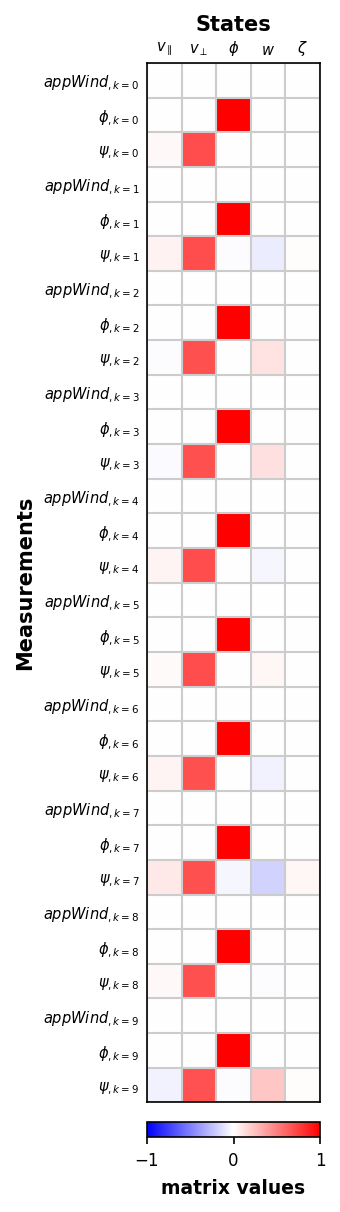

In [62]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[-1].O)
OI.plot()

# Plot error variance as color on state time-series

In [63]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

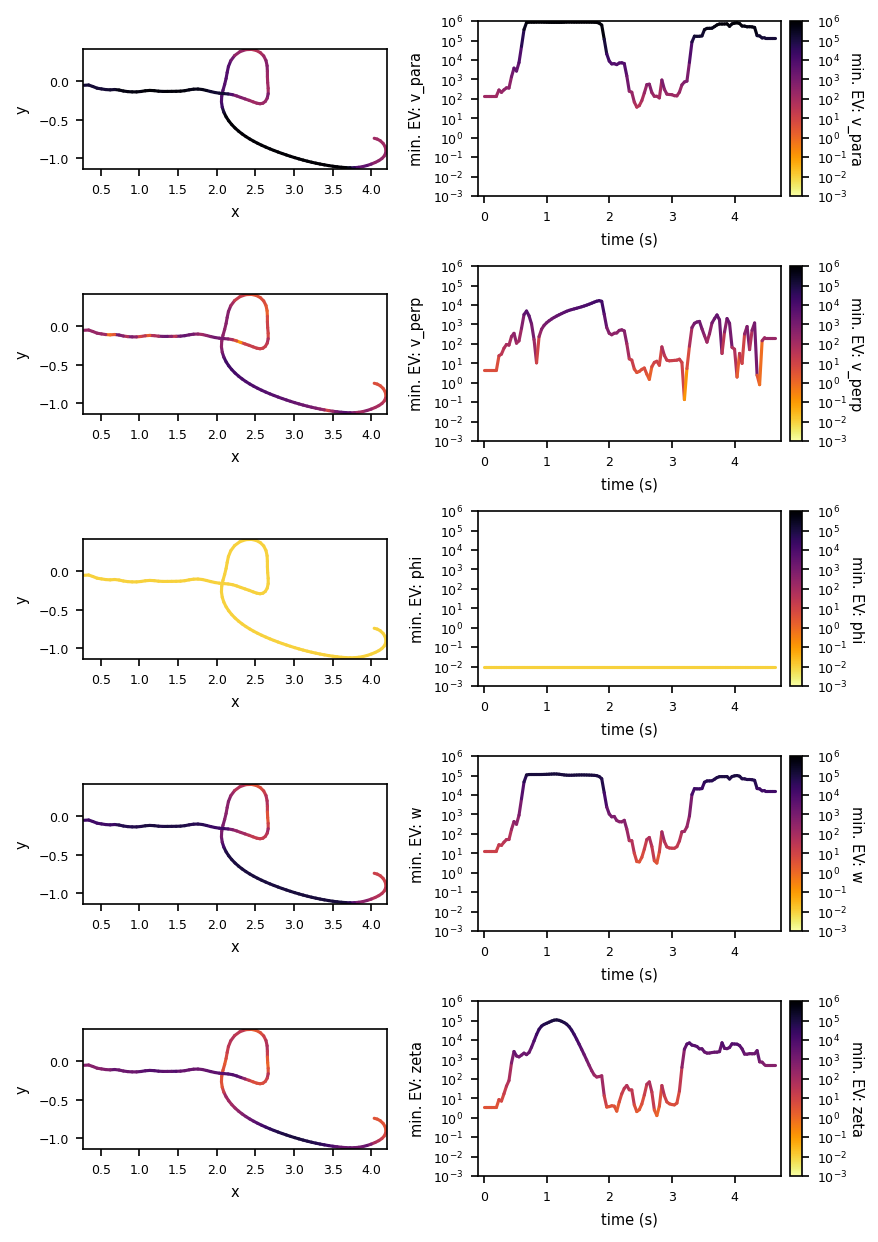

In [64]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)
    
# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()